Week 2

Let k be the number of members in your group (k ∈ {1,2,3}). Implement k different7 language models for each of the three languages, separately for the questions and the documents (total k×3×2 language models), using the training data. Evaluate each of them on the validation data, report their performance and discuss the results.


In [1]:
# Preamble 
import sys 
sys.path.append('..')

In [2]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("copenlu/answerable_tydiqa")

train_set = dataset["train"]
validation_set = dataset["validation"]

df_train = train_set.to_pandas()
df_val = validation_set.to_pandas()

df_train.head()


,question_text,document_title,language,annotations,document_plaintext,document_url
0,Milloin Charles Fort syntyi?,Charles Fort,finnish,"{'answer_start': [18], 'answer_text': ['6. elo...",Charles Hoy Fort (6. elokuuta (joidenkin lähte...,https://fi.wikipedia.org/wiki/Charles%20Fort
1,“ダン” ダニエル・ジャドソン・キャラハンの出身はどこ,ダニエル・J・キャラハン,japanese,"{'answer_start': [35], 'answer_text': ['カリフォルニ...",“ダン”こと、ダニエル・ジャドソン・キャラハンは1890年7月26日、カリフォルニア州サンフ...,https://ja.wikipedia.org/wiki/%E3%83%80%E3%83%...
2,వేప చెట్టు యొక్క శాస్త్రీయ నామం ఏమిటి?,వేప,telugu,"{'answer_start': [12], 'answer_text': ['Azadir...","వేప (లాటిన్ Azadirachta indica, syn. Melia aza...",https://te.wikipedia.org/wiki/%E0%B0%B5%E0%B1%...
3,চেঙ্গিস খান কোন বংশের রাজা ছিলেন ?,চেঙ্গিজ খান,bengali,"{'answer_start': [414], 'answer_text': ['বোরজি...",চেঙ্গিজ খান (মঙ্গোলীয়: Чингис Хаан আ-ধ্ব-ব: ...,https://bn.wikipedia.org/wiki/%E0%A6%9A%E0%A7%...
4,రెయ్యలగడ్ద గ్రామ విస్తీర్ణత ఎంత?,రెయ్యలగడ్ద,telugu,"{'answer_start': [259], 'answer_text': ['27 హె...","రెయ్యలగడ్ద, విశాఖపట్నం జిల్లా, గంగరాజు మాడుగుల...",https://te.wikipedia.org/wiki/%E0%B0%B0%E0%B1%...


In [3]:
# Get train and validation data for each language
df_train_bengali = df_train[df_train['language'] == 'bengali']
df_train_arabic = df_train[df_train['language'] == 'arabic']
df_train_indonesian = df_train[df_train['language'] == 'indonesian']

df_val_bengali = df_val[df_val['language'] == 'bengali']
df_val_arabic = df_val[df_val['language'] == 'arabic']
df_val_indonesian = df_val[df_val['language'] == 'indonesian']

print(len(df_train_bengali))
print(len(df_train_arabic))
print(len(df_train_indonesian))

# For testing
df_val_english = df_val[df_val['language'] == 'english']
df_train_english = df_train[df_train['language'] == 'english']


4779
29598
11394


In [4]:
df_train_bengali_document = df_train[df_train['language'] == 'bengali']["document_plaintext"]
df_train_arab_document = df_train[df_train['language'] == 'arabic']["document_plaintext"]
df_train_indonesian_document = df_train[df_train['language'] == 'indonesian']["document_plaintext"]
df_train_indonesian_document.head()

df_train_english_document = df_train[df_train['language'] == 'english']["document_plaintext"]


In [5]:
# Tokenize the documents
from transformers import AutoTokenizer
mbert_tokeniser = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

def tokenize(df, key, transformer_model):
  df.loc[:, f'{key}_tokenized'] = [transformer_model.tokenize(row) for row in df[key]]

# Tokinize train document_plaintext
tokenize(df_train_bengali, "document_plaintext", mbert_tokeniser)
tokenize(df_train_arabic, "document_plaintext", mbert_tokeniser)
tokenize(df_train_indonesian, "document_plaintext", mbert_tokeniser)

# Tokinize validation document_plaintext
tokenize(df_val_bengali, "document_plaintext", mbert_tokeniser)
tokenize(df_val_arabic, "document_plaintext", mbert_tokeniser)
tokenize(df_val_indonesian, "document_plaintext", mbert_tokeniser)


# For testing
tokenize(df_train_english, "document_plaintext", mbert_tokeniser)
tokenize(df_val_english, "document_plaintext", mbert_tokeniser)



Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
/var/folders/96/51nz4vj53xj0q5n07407wbrr0000gq/T/ipykernel_9135/3821323326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{key}_tokenized'] = [transformer_model.tokenize(row) for row in df[key]]
/var/folders/96/51nz4vj53xj0q5n07407wbrr0000gq/T/ipykernel_9135/3821323326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [6]:
from statnlpbook.lm import NGramLM, UniformLM, inject_OOVs, perplexity, replace_OOVs

# Training data document_plaintext tokenized
document_plaintext_tokenized_bengali = list(df_train_bengali["document_plaintext_tokenized"].explode())
document_plaintext_tokenized_arabic = list(df_train_arabic["document_plaintext_tokenized"].explode())
document_plaintext_tokenized_indonesian = list(df_train_indonesian["document_plaintext_tokenized"].explode())

# Validation data document_plaintext tokenized
document_plaintext_tokenized_val_bengali = list(df_val_bengali["document_plaintext_tokenized"].explode())
document_plaintext_tokenized_val_arabic = list(df_val_arabic["document_plaintext_tokenized"].explode())
document_plaintext_tokenized_val_indonesian = list(df_val_indonesian["document_plaintext_tokenized"].explode())

def perplexity_uniform(train, test):
    oov_train = inject_OOVs(train)
    oov_vocab = set(oov_train)
    oov_test = replace_OOVs(oov_vocab, test)
    oov_baseline = UniformLM(oov_vocab)
    return perplexity(oov_baseline,oov_test)

print("Bengali perplexity UniformLM:",perplexity_uniform(document_plaintext_tokenized_bengali, document_plaintext_tokenized_val_bengali))
print("Arabic perplexity UniformLM:",perplexity_uniform(document_plaintext_tokenized_arabic, document_plaintext_tokenized_val_arabic))
print("Indonesian perplexity UniformLM:",perplexity_uniform(document_plaintext_tokenized_indonesian, document_plaintext_tokenized_val_indonesian))


Bengali perplexity UniformLM: 3623.9999999845454
Arabic perplexity UniformLM: 11174.000000245973
Indonesian perplexity UniformLM: 18974.000000269545


Unigram 3623.9999999845454
Unigram 371.19288552880323


/Users/private/Desktop/nlp-course/.venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2404 (\N{DEVANAGARI DANDA}) missing from current font.
  func(*args, **kwargs)
/Users/private/Desktop/nlp-course/.venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/Users/private/Desktop/nlp-course/.venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  func(*args, **kwargs)
/Users/private/Desktop/nlp-course/.venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Matplotlib currently does not support Bengali natively.
  func(*args, **kwargs)
/Users/private/Desktop/nlp-course/.venv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from current font.
  func(*args, **kwargs)
/Users/private/Desktop/nlp-course/.venv/

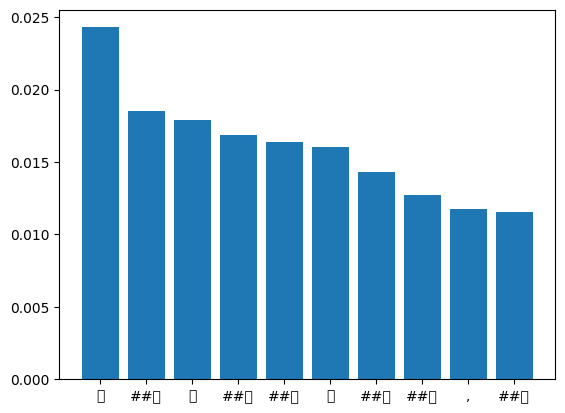

In [7]:
from statnlpbook.lm import inject_OOVs, perplexity, replace_OOVs
from statnlpbook import util

def plot_probabilities(lm, context = (), how_many = 10):
    probs = sorted([(word,lm.probability(word,*context)) for word in lm.vocab], key=lambda x:x[1], reverse=True)[:how_many]
    util.plot_bar_graph([prob for _,prob in probs], [word for word, _ in probs])

oov_train = inject_OOVs(df_train_bengali["document_plaintext_tokenized"].explode().tolist())
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, df_val_bengali["document_plaintext_tokenized"].explode().tolist())
oov_4 = NGramLM(oov_train, 1)
# perplexity(oov_baseline, oov_test)
oov_baseline = UniformLM(oov_vocab)
print("Unigram" ,perplexity(oov_baseline,oov_test))
print("Unigram" ,perplexity(oov_4, oov_test))

plot_probabilities(oov_4)
# oov_train = inject_OOVs(train)
# oov_vocab = set(oov_train)
# oov_test = replace_OOVs(oov_vocab, test)
# oov_baseline = UniformLM(oov_vocab)
# perplexity(oov_baseline,oov_test)


In [8]:
oov_train = inject_OOVs(df_train_english["document_plaintext_tokenized"].explode().tolist())
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, df_val_english["document_plaintext_tokenized"].explode().tolist())
oov_4 = NGramLM(oov_train, 2)
# perplexity(oov_baseline, oov_test)
oov_baseline = UniformLM(oov_vocab)
print("Unigram" ,perplexity(oov_baseline,oov_test))
print("Unigram" ,perplexity(oov_4, oov_test))

# oov_4.probability("this", ("what", "is"))

list(oov_vocab)[:100]

Unigram 21025.99999985167
Unigram inf


['1509',
 'jacksonville',
 'chairman',
 'guangzhou',
 '##iding',
 'dental',
 'tomorrow',
 'simulation',
 '##ility',
 'liquid',
 'shoot',
 'merci',
 'temporary',
 'invisible',
 'masse',
 'ser',
 '##lal',
 '##rige',
 'lithuanian',
 'tag',
 'friesland',
 'mag',
 'papal',
 'common',
 '625',
 '1270',
 'guerrilla',
 '##minen',
 'comparison',
 'doherty',
 'colle',
 'officers',
 '##rnich',
 'gaga',
 'foren',
 '155',
 'riviere',
 'messages',
 'kom',
 'exist',
 '##zation',
 'intera',
 'dieta',
 'umbria',
 '##he',
 'craig',
 'behaviour',
 'toured',
 '##mu',
 'heroi',
 'lester',
 '##tile',
 'r2',
 'national',
 'produce',
 'passion',
 '##dr',
 '##nar',
 'sato',
 'more',
 '351',
 'mauritania',
 'alma',
 'heavy',
 '##er',
 'ard',
 '##jing',
 'loose',
 '##hibition',
 'potentially',
 '##utan',
 'commissioner',
 '##tore',
 'experiences',
 '##rint',
 'wives',
 '##cili',
 'elo',
 '77',
 '1852',
 'decca',
 '##ʊ',
 '##lco',
 'there',
 'sensitive',
 '##elt',
 '##ism',
 'yellow',
 'hastings',
 'wooden',
 '139